In [185]:
import pandas as pd
import json
import numpy as np
import operator
import matplotlib.pyplot as plt
from collections import Counter
import os
import time
import pickle
import networkx as nx
import string
import seaborn as sns
from random import sample
sns.set_palette('pastel')
import matplotsoccer
from shapely.geometry import box, Point

pd.options.mode.chained_assignment = None  # default='warn'
ROOT = os.path.dirname(os.getcwd())
ROOT = os.path.dirname(os.getcwd())
teams = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'teams.pkl.gz'))
players = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'players.pkl.gz'))
players['shortName'] = players['shortName'].apply(lambda s: ''.join([x for x in s if x.isalpha() or x in [' ', '.'] ]))
player_mapping = {row['wyId'] : row['shortName'] for i, row in players.iterrows()}
teams['officialName'] = teams['officialName'].apply(lambda s: ''.join([x for x in s if x.isalpha() or x in [' ', '.'] ]))

# Approach
Taking passing events and noting down how many passes originate at certain zones on the field

In [186]:
events = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'events_df.pkl.gz'))
events_passing = events.loc[events['eventName']=='Pass']
events_passing.head(5)

eventId subEventName            tags  playerId  \
Italy 0         8  Simple pass  [{'id': 1801}]      8327   
      1         8  Simple pass  [{'id': 1801}]     20438   
      5         8  Simple pass  [{'id': 1801}]      8306   
      10        8  Simple pass  [{'id': 1801}]     86366   
      14        8  Simple pass  [{'id': 1801}]      8306   

                                         positions  matchId eventName  teamId  \
Italy 0   [{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]  2575959      Pass    3158   
      1   [{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]  2575959      Pass    3158   
      5   [{'y': 15, 'x': 72}, {'y': 25, 'x': 72}]  2575959      Pass    3158   
      10  [{'y': 82, 'x': 38}, {'y': 88, 'x': 43}]  2575959      Pass    3172   
      14  [{'y': 15, 'x': 61}, {'y': 15, 'x': 37}]  2575959      Pass    3158   

         matchPeriod   eventSec subEventId         id  
Italy 0           1H   2.530536         85  180423957  
      1           1H   3.768418         85  180423958  
      5           1H  10.376066         85  180423962  
      10          1H  16.240563         85  180423979  
      14          1H  19.153235         85  180423968

### Visualization

<Figure size 432x288 with 0 Axes>

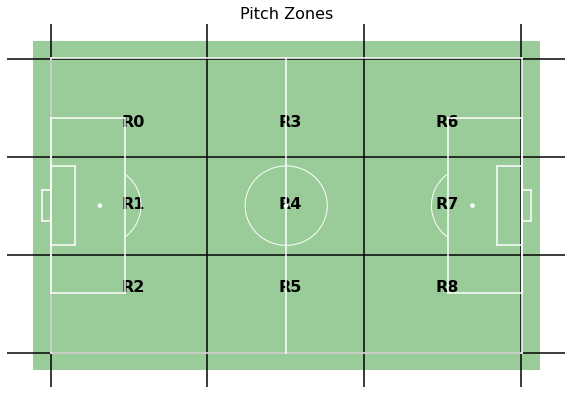

In [187]:
def scale_coords(num: int, coord='x') -> float:
    '''
    Scale x to (0, 105) and y to (0, 68). Both are originally percentages
    '''
    if coord=='x':
        return num/100 * 105
    elif coord=='y':
        return num/100 * 68
    else:
        raise Exception("coord must be 'x' or 'y'")
        
def identify_region(x: int, y: int) -> int:
    p = Point(x, y)
    
    if p.within(box(0, 200/3, 100/3, 100)):
        return 0
    elif p.within(box(0, 100/3, 100/3, 200/3)):
        return 1
    elif p.within(box(0, 0, 100/3, 100/3)):
        return 2
    
    elif p.within(box(100/3, 200/3, 200/3, 100)):
        return 3
    elif p.within(box(100/3, 100/3, 200/3, 200/3)):
        return 4
    elif p.within(box(100/3, 0, 200/3, 100/3)):
        return 5
    
    elif p.within(box(200/3, 200/3, 100, 100)):
        return 6
    elif p.within(box(200/3, 100/3, 100, 200/3)):
        return 7
    elif p.within(box(200/3, 0, 100, 100/3)):
        return 8
    
    else:
        return np.nan
        
    
def plot_passes(df_player, ax, color='blue'):
    
    for i in range(len(df_player)):
        # annotate draw an arrow from a current position to pass_end_location
        ax.annotate("", xy = (df_player.iloc[i]['pass_destination'][0], df_player.iloc[i]['pass_destination'][1]), xycoords = 'data',
                   xytext = (df_player.iloc[i]['pass_origin'][0], df_player.iloc[i]['pass_origin'][1]), textcoords = 'data',
                   arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = color),)


#dimensions are always 105x65 -> scale x to (0, 105) and y to (0, 68)
plt.figure()
matplotsoccer.field("green",figsize=10, show=False)

#Vertical & Horizontal Lines
_ = [plt.axvline(scale_coords(i, 'x'), color='k') for i in [0.01, 33.3, 66.6, 99.9]]
_ = [plt.axhline(scale_coords(i, 'y'), color='k') for i in [0.01, 33.3, 66.6, 99.9]]

#Labels
_ = [plt.text(scale_coords(i*33.3 + 15, 'x'), scale_coords(77, 'y'), 'R{}'.format(3*i), fontsize=16, color='k', weight='bold') for i in range(3)]
_ = [plt.text(scale_coords(i*33.3 + 15, 'x'), scale_coords(49, 'y'), 'R{}'.format(3*i+1), fontsize=16, color='k', weight='bold') for i in range(3)]
_ = [plt.text(scale_coords(i*33.3 + 15, 'x'), scale_coords(21, 'y'), 'R{}'.format(3*i+2), fontsize=16, color='k', weight='bold') for i in range(3)]

plt.title('Pitch Zones', fontsize=16)
plt.savefig(os.path.join(ROOT, 'figures' ,'pitch_regions.png'))
plt.show()

### Note from documentation:
positions: the origin and destination positions associated with the event. Each position is a pair of coordinates (x, y). The x and y coordinates are always in the range [0, 100] and indicate the percentage of the field from the perspective of the attacking team. In particular, the value of the x coordinate indicates the event’s nearness (in percentage) to the opponent’s goal, while the value of the y coordinates indicates the event’s nearness (in percentage) to the right side of the field;



In [188]:
matchId = 2499719

#Get the time for the latest event in the first half for this match
end_first_half = events.loc[(events['matchId']==matchId)
                            &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]



df = events_passing.loc[(events_passing['matchId']==matchId)]
team1, team2 = df['teamId'].unique()
df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
#df = df[['playerId', 'positions', 'teamId', 'time']]

df['pass_origin'] = df['positions'].apply(lambda pos: [scale_coords(pos[0]['x'], coord='x'), scale_coords(pos[0]['y'], coord='y')])
df['pass_destination'] = df['positions'].apply(lambda pos: [scale_coords(pos[1]['x'], coord='x'), scale_coords(pos[1]['y'], coord='y')])

df.head(10)

eventId subEventName                          tags  playerId  \
England 0         8  Simple pass                [{'id': 1801}]     25413   
        1         8    High pass                [{'id': 1801}]    370224   
        2         8    Head pass                [{'id': 1801}]      3319   
        3         8    Head pass                [{'id': 1801}]    120339   
        4         8  Simple pass                [{'id': 1801}]    167145   
        5         8  Simple pass                [{'id': 1802}]      3319   
        6         8    Head pass                [{'id': 1801}]      8653   
        9         8    Head pass  [{'id': 1401}, {'id': 1801}]    167145   
        10        8    Head pass                [{'id': 1801}]     49876   
        11        8    High pass                [{'id': 1801}]     14869   

                                           positions  matchId eventName  \
England 0   [{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]  2499719      Pass   
        1   [{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]  2499719      Pass   
        2   [{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]  2499719      Pass   
        3   [{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]  2499719      Pass   
        4   [{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]  2499719      Pass   
        5   [{'y': 88, 'x': 72}, {'y': 75, 'x': 77}]  2499719      Pass   
        6   [{'y': 25, 'x': 23}, {'y': 15, 'x': 39}]  2499719      Pass   
        9   [{'y': 80, 'x': 67}, {'y': 61, 'x': 59}]  2499719      Pass   
        10  [{'y': 61, 'x': 59}, {'y': 45, 'x': 45}]  2499719      Pass   
        11  [{'y': 45, 'x': 45}, {'y': 54, 'x': 71}]  2499719      Pass   

            teamId matchPeriod   eventSec subEventId         id       time  \
England 0     1609          1H   2.758649         85  177959171   2.758649   
        1     1609          1H   4.946850         83  177959172   4.946850   
        2     1609          1H   6.542188         82  177959173   6.542188   
        3     1609          1H   8.143395         82  177959174   8.143395   
        4     1609          1H  10.302366         85  177959175  10.302366   
        5     1609          1H  12.548934         85  177959177  12.548934   
        6     1631          1H  13.961228         82  177959186  13.961228   
        9     1609          1H  15.320341         82  177959178  15.320341   
        10    1609          1H  18.051875         82  177959179  18.051875   
        11    1609          1H  20.426527         83  177959180  20.426527   

                                        pass_origin  \
England 0               [51.449999999999996, 33.32]   
        1                            [32.55, 53.04]   
        2                [53.550000000000004, 51.0]   
        3                            [36.75, 48.28]   
        4                             [43.05, 64.6]   
        5                             [75.6, 59.84]   
        6                [24.150000000000002, 17.0]   
        9   [70.35000000000001, 54.400000000000006]   
        10              [61.949999999999996, 41.48]   
        11                            [47.25, 30.6]   

                       pass_destination  
England 0                [32.55, 53.04]  
        1    [53.550000000000004, 51.0]  
        2                [36.75, 48.28]  
        3                 [43.05, 64.6]  
        4                 [75.6, 59.84]  
        5     [80.85000000000001, 51.0]  
        6                 [40.95, 10.2]  
        9   [61.949999999999996, 41.48]  
        10                [47.25, 30.6]  
        11               [74.55, 36.72]

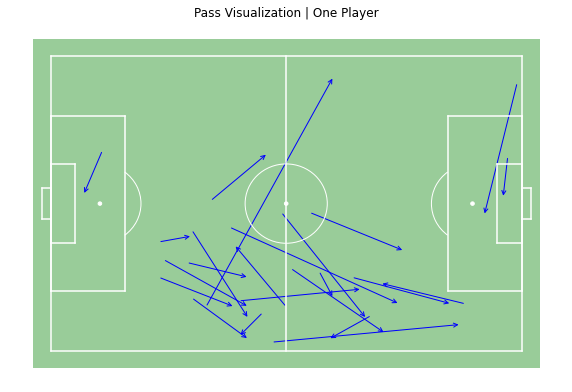

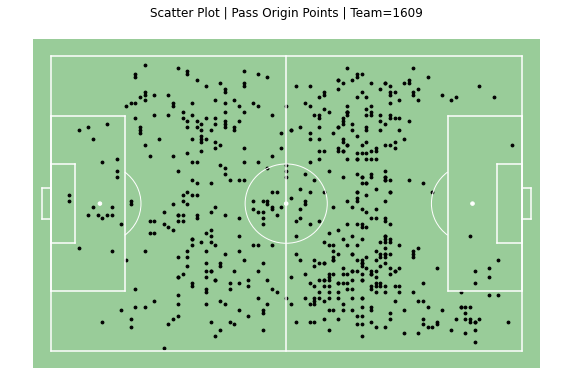

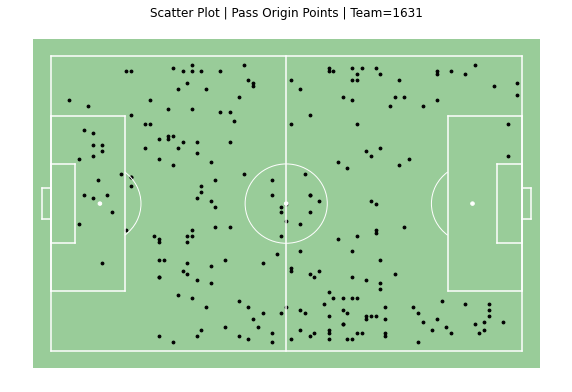

In [189]:
df_player = df.loc[df['playerId']==8653]

ax = matplotsoccer.field("green",figsize=10, show=False)
plot_passes(df_player, ax)
plt.title('Pass Visualization | One Player')
plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'sample_player_pass_visualization.png'))
plt.show()


df_team = df.loc[df['teamId']==team1]
ax = matplotsoccer.field("green",figsize=10, show=False)
ax.scatter(x = [df_team.iloc[i]['pass_origin'][0] for i in range(len(df_team))],
          y = [df_team.iloc[i]['pass_origin'][1] for i in range(len(df_team))],
          color='k', s=8)
plt.title('Scatter Plot | Pass Origin Points | Team={}'.format(team1))
plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'pass_origin_scatter_1.png'))
plt.show()

df_team = df.loc[df['teamId']==team2]
ax = matplotsoccer.field("green",figsize=10, show=False)
ax.scatter(x = [df_team.iloc[i]['pass_origin'][0] for i in range(len(df_team))],
          y = [df_team.iloc[i]['pass_origin'][1] for i in range(len(df_team))],
          color='k', s=8)
plt.title('Scatter Plot | Pass Origin Points | Team={}'.format(team2))
plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'pass_origin_scatter_2.png'))
plt.show()


Lets group all passes by the region they originate in and visualize the histograms

In [178]:
df['zone_origin'] = df['positions'].apply(lambda pos: identify_region(pos[0]['x'], pos[0]['y']))
df['zone_destination'] = df['positions'].apply(lambda pos: identify_region(pos[1]['x'], pos[1]['y']))
df = df.drop(columns = 'positions').set_index('teamId').sort_index()
df

,eventId,subEventName,tags,playerId,matchId,eventName,matchPeriod,eventSec,subEventId,id,time,pass_origin,pass_destination,zone_origin,zone_destination
teamId,,,,,,,,,,,,,,,
1609,8,Simple pass,[{'id': 1801}],25413,2499719,Pass,1H,2.758649,85,177959171,2.758649,"[51.449999999999996, 33.32]","[32.55, 53.04]",4,0.0
1609,8,Simple pass,[{'id': 1802}],7868,2499719,Pass,2H,363.703116,85,177960234,3216.260497,"[91.35, 10.2]","[87.14999999999999, 3.4000000000000004]",8,8.0
1609,8,Simple pass,[{'id': 1802}],7945,2499719,Pass,2H,393.577800,85,177960245,3246.135181,"[78.75, 4.08]","[73.5, 2.04]",8,8.0
1609,8,Simple pass,[{'id': 1801}],49876,2499719,Pass,2H,399.722259,85,177960248,3252.279640,"[65.1, 25.84]","[58.800000000000004, 14.96]",4,5.0
1609,8,Simple pass,[{'id': 1801}],14869,2499719,Pass,2H,400.916375,85,177960249,3253.473756,"[58.800000000000004, 14.96]","[57.75000000000001, 6.800000000000001]",5,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,8,Simple pass,[{'id': 1801}],8013,2499719,Pass,2H,295.891786,85,177960241,3148.449167,"[61.949999999999996, 2.72]","[74.55, 7.48]",5,8.0
1631,8,Cross,"[{'id': 402}, {'id': 801}, {'id': 1801}]",8653,2499719,Pass,1H,746.497280,80,177959414,746.497280,"[103.95, 61.88]","[96.60000000000001, 31.28]",6,7.0
1631,8,Simple pass,[{'id': 1801}],149019,2499719,Pass,1H,740.890856,85,177959411,740.890856,"[70.35000000000001, 46.24]","[89.25, 61.2]",6,6.0


<AxesSubplot:xlabel='zone_origin'>

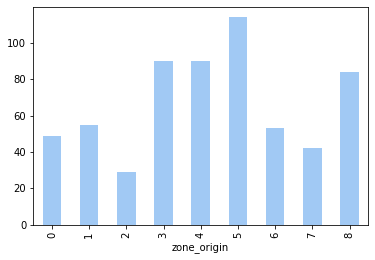

In [179]:
df_team1 = df.loc[(df.index==team1)].reset_index()
df_team1.groupby(by='zone_origin').count().iloc[:, 0].plot(kind='bar')

<AxesSubplot:xlabel='zone_origin'>

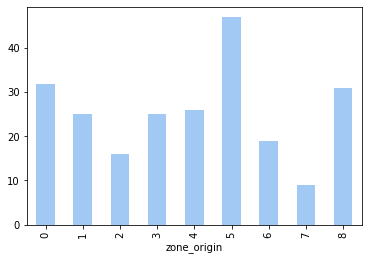

In [180]:
df_team2 = df.loc[(df.index==team2)].reset_index()
df_team2.groupby(by='zone_origin').count().iloc[:, 0].plot(kind='bar')

### Streamlining For All Games

In [181]:
matches = sorted(events['matchId'].unique())
n = len(matches)

zonal_info = dict()


for i, matchId in enumerate(matches):

    if i % 50 == 0: print('{}/{}'.format(i, n))
        
    #Get the time for the latest event in the first half for this match
    end_first_half = events.loc[(events['matchId']==matchId)
                                &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]



    df = events_passing.loc[(events_passing['matchId']==matchId)]
    team1, team2 = df['teamId'].unique()
    
    df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
    #df = df[['playerId', 'positions', 'teamId', 'time']]

    df['pass_origin'] = df['positions'].apply(lambda pos: [scale_coords(pos[0]['x'], coord='x'), scale_coords(pos[0]['y'], coord='y')])
    df['pass_destination'] = df['positions'].apply(lambda pos: [scale_coords(pos[1]['x'], coord='x'), scale_coords(pos[1]['y'], coord='y')])

    df['zone_origin'] = df['positions'].apply(lambda pos: identify_region(pos[0]['x'], pos[0]['y']))
    df['zone_destination'] = df['positions'].apply(lambda pos: identify_region(pos[1]['x'], pos[1]['y']))
    df = df.drop(columns = 'positions').set_index('teamId').sort_index()
    zonal_info[matchId] = df
    
    

0/1826
50/1826
100/1826
150/1826
200/1826
250/1826
300/1826
350/1826
400/1826
450/1826
500/1826
550/1826
600/1826
650/1826
700/1826
750/1826
800/1826
850/1826
900/1826
950/1826
1000/1826
1050/1826
1100/1826
1150/1826
1200/1826
1250/1826
1300/1826
1350/1826
1400/1826
1450/1826
1500/1826
1550/1826
1600/1826
1650/1826
1700/1826
1750/1826
1800/1826


In [182]:
zonal_info = pd.concat(zonal_info, axis=0)
zonal_info

eventId subEventName                          tags  playerId  \
        teamId                                                                 
2499719 1609          8  Simple pass                [{'id': 1801}]     25413   
        1609          8  Simple pass                [{'id': 1802}]      7868   
        1609          8  Simple pass                [{'id': 1802}]      7945   
        1609          8  Simple pass                [{'id': 1801}]     49876   
        1609          8  Simple pass                [{'id': 1801}]     14869   
...                 ...          ...                           ...       ...   
2576338 3193          8  Simple pass  [{'id': 1401}, {'id': 1801}]    206318   
        3193          8  Simple pass                [{'id': 1801}]    345740   
        3193          8  Simple pass                [{'id': 1801}]     21468   
        3193          8    Head pass                [{'id': 1802}]    413041   
        3193          8  Simple pass                [{'id': 1802}]    345740   

                matchId eventName matchPeriod     eventSec subEventId  \
        teamId                                                          
2499719 1609    2499719      Pass          1H     2.758649         85   
        1609    2499719      Pass          2H   363.703116         85   
        1609    2499719      Pass          2H   393.577800         85   
        1609    2499719      Pass          2H   399.722259         85   
        1609    2499719      Pass          2H   400.916375         85   
...                 ...       ...         ...          ...        ...   
2576338 3193    2576338      Pass          2H     6.489681         85   
        3193    2576338      Pass          2H    12.714039         85   
        3193    2576338      Pass          2H    15.327703         85   
        3193    2576338      Pass          1H  2654.748427         82   
        3193    2576338      Pass          2H  2812.814903         85   

                       id         time  \
        teamId                           
2499719 1609    177959171     2.758649   
        1609    177960234  3216.260497   
        1609    177960245  3246.135181   
        1609    177960248  3252.279640   
        1609    177960249  3253.473756   
...                   ...          ...   
2576338 3193    253566109  2881.566065   
        3193    253566114  2887.790423   
        3193    253566115  2890.404087   
        3193    253566040  2654.748427   
        3193    253567149  5687.891287   

                                             pass_origin  \
        teamId                                             
2499719 1609                 [51.449999999999996, 33.32]   
        1609                               [91.35, 10.2]   
        1609                               [78.75, 4.08]   
        1609                               [65.1, 25.84]   
        1609                 [58.800000000000004, 14.96]   
...                                                  ...   
2576338 3193                               [31.5, 59.84]   
        3193                 [29.400000000000002, 65.96]   
        3193                  [12.6, 37.400000000000006]   
        3193    [55.650000000000006, 3.4000000000000004]   
        3193                  [70.35000000000001, 48.28]   

                                       pass_destination  zone_origin  \
        teamId                                                         
2499719 1609                             [32.55, 53.04]          4.0   
        1609    [87.14999999999999, 3.4000000000000004]          8.0   
        1609                               [73.5, 2.04]          8.0   
        1609                [58.800000000000004, 14.96]          4.0   
        1609     [57.75000000000001, 6.800000000000001]          5.0   
...                                                 ...          ...   
2576338 3193                [40.95, 63.919999999999995]          0.0   
        3193                 [12.6, 37.4000000000

In [183]:
zonal_info.to_pickle(os.path.join(ROOT, 'intermediates', 'zonal_info_combined.pkl.gz'))
zonal_info.to_csv(os.path.join(ROOT, 'intermediates', 'zonal_info_combined.csv'))

# Using Zones For Stationarity
Just sampling 5 teams, making origin, destination histograms for all zones (x and y), for every game in the season. Will later compare these visually


In [174]:
teams = sorted(zonal_info.index.get_level_values(1).unique())

    
#Each Team
for teamId in teams:
    print(teamId)
    team_df = zonal_info.loc[zonal_info.index.get_level_values(1)==teamId]
    if not os.path.exists(os.path.join(ROOT, 'figures', 'stationarity_investigation', 'zone_combined', 'team_{}'.format(teamId))):
        os.makedirs(os.path.join(ROOT, 'figures', 'stationarity_investigation', 'zone_combined', 'team_{}'.format(teamId)))

    #Each Match
    for matchId in team_df.index.get_level_values(0).unique():
        match_df = team_df.loc[matchId]
        fig, axes = plt.subplots(1, 1, figsize=(12, 5))
        match_df.reset_index().groupby(by='zone_origin').count().iloc[:, 0].plot(kind='bar', ax=axes)
        plt.suptitle('Pass Origin Zone | Match: {}'.format(matchId))
        plt.tight_layout()
        plt.savefig(os.path.join(ROOT, 'figures', 'stationarity_investigation', 'zone_combined', 'team_{}'.format(teamId), '{}.png'.format(matchId)))   
        plt.close()

674
675
676
677
678
679
680
682
683
684
687
691
692
695
696
698
701
712
714
756
1609
1610
1611
1612
1613
1619
1623
1624
1625
1627
1628
1631
1633
1639
1644
1646
1651
1659
1673
2443
2444
2445
2446
2447
2449
2450
2451
2453
2454
2455
2457
2460
2462
2463
2481
2482
2975
3157
3158
3159
3161
3162
3163
3164
3165
3166
3172
3173
3176
3185
3187
3193
3194
3197
3204
3219
3315
3766
3767
3770
3771
3772
3774
3775
3776
3777
3779
3780
3782
3783
3785
3787
3789
3795
3799
3804
10531
19830


In [171]:
len(teams)

98

In [97]:


Point(0.5, 0.99999).within(b)

True